<a href="https://colab.research.google.com/github/vasantvohra/Offline-Signature-Verification-using-Siamese-Network/blob/master/SigNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import necessary libraries and functions

In [ ]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Path to store weights

In [ ]:
path='/content/drive/My Drive/Weights/'
dir_list = os.listdir(path) 
print(dir_list)

[]


Dataset of signatures

In [ ]:
path = r"/content/drive/My Drive/dataset"

In [ ]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [ ]:
dir_list

['full_forg', 'full_org']

## Generate forged groups of 55 people with 24 signatures and 6 known people with 12*2 signatures.
open source dataset - https://www.kaggle.com/general/69897 |https://cedar.buffalo.edu/NIJ/data/signatures.rar

In [ ]:
forg_groups = []
for i in dir_list[0]:
    images = os.listdir(path+'/'+dir_list[0])
    images.sort()
    images.remove('Thumbs.db')
    images = [path+'/'+ dir_list[0] + '/'+ x for x in images]

print(len(images))
i=0
j=12
for _ in range(0,61):#57    
    forg_groups.append(images[i:j])
    i=j
    j+=12
forg_groups[60]

732


['/content/drive/My Drive/dataset/full_forg/forgeries_9_1.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_10.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_11.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_12.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_2.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_3.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_4.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_5.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_6.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_7.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_8.png',
 '/content/drive/My Drive/dataset/full_forg/forgeries_9_9.png']

## Generate original groups of 55 people with 24 signatures and 6 known people with 12*2 signatures.

In [ ]:
orig_groups= []
for i in dir_list[0]:
    images = os.listdir(path+'/'+dir_list[1])
    images.sort()
    images.remove('Thumbs.db')
    images = [path+'/'+ dir_list[1] + '/'+ x for x in images]

print(len(images))
i=0
j=12
for _ in range(0,61):    
    orig_groups.append(images[i:j])
    i=j
    j+=12
orig_groups[60]

732


['/content/drive/My Drive/dataset/full_org/original_9_1.png',
 '/content/drive/My Drive/dataset/full_org/original_9_10.png',
 '/content/drive/My Drive/dataset/full_org/original_9_11.png',
 '/content/drive/My Drive/dataset/full_org/original_9_12.png',
 '/content/drive/My Drive/dataset/full_org/original_9_2.png',
 '/content/drive/My Drive/dataset/full_org/original_9_3.png',
 '/content/drive/My Drive/dataset/full_org/original_9_4.png',
 '/content/drive/My Drive/dataset/full_org/original_9_5.png',
 '/content/drive/My Drive/dataset/full_org/original_9_6.png',
 '/content/drive/My Drive/dataset/full_org/original_9_7.png',
 '/content/drive/My Drive/dataset/full_org/original_9_8.png',
 '/content/drive/My Drive/dataset/full_org/original_9_9.png']

In [ ]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(61, 61)

In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [ ]:
# Quick check to confirm that there are 12 Genuine signatures for each individual
flag=0
for i in range(0,len(orig_lengths)):
	for j in range(i+1,len(orig_lengths)):
		       if orig_lengths[i]==orig_lengths[j]:
			       flag=1
print(flag)

In [ ]:
# Quick check to confirm that there are 12 Genuine signatures for each individual
print(orig_lengths)

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


In [ ]:
# Quick check to confirm that there are 12 Forged signatures for each individual
flag=0
for i in range(0,len(forg_lengths)):
	for j in range(i+1,len(forg_lengths)):
		       if forg_lengths[i]==forg_lengths[j]:
			       flag=1
print(flag)

In [ ]:
# Quick check to confirm that there are 12 Forged signatures for each individual
print(forg_lengths)

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


#### Train-Validation-Test Split
* Signatures of 40 people are used for training
* Signatures of 15 people are used for validation
* Signatures of 06 people are used for testing

In [ ]:
#orig_train, orig_val, orig_test = orig_groups[:1224], orig_groups[1224:], orig_groups[1320:]
#forg_train, forg_val, forg_test = forg_groups[:1224], forg_groups[1224:], forg_groups[1320:]
#orig_train, orig_val, orig_test = orig_groups[:1176], orig_groups[1200:1320], orig_groups[1320:]
#forg_train, forg_val, forg_test = forg_groups[:1176], forg_groups[1200:1320], forg_groups[1320:]

orig_train, orig_val, orig_test = orig_groups[:40], orig_groups[40:55], orig_groups[55:]
forg_train, forg_val, forg_test = forg_groups[:40], forg_groups[40:55], forg_groups[55:]

In [ ]:
len(orig_groups[55:])

6

In [ ]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [ ]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

Visualize the signature

In [ ]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    #Random
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img  =  plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img  =  cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

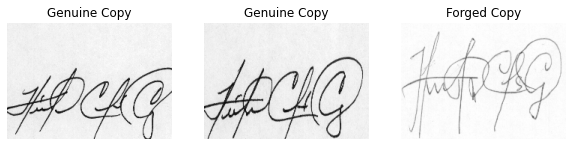

In [ ]:
visualize_sample_signature()

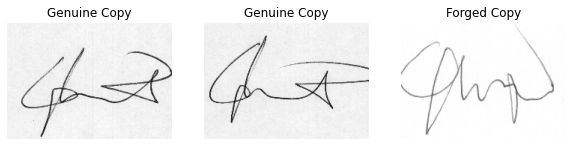

In [ ]:
visualize_sample_signature()

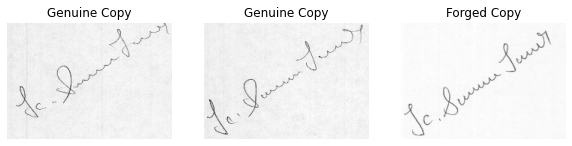

In [ ]:
visualize_sample_signature()

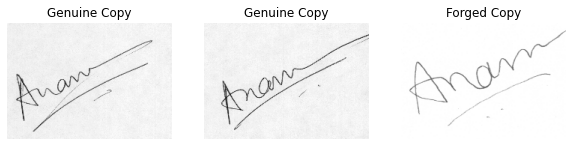

In [ ]:
visualize_sample_signature()

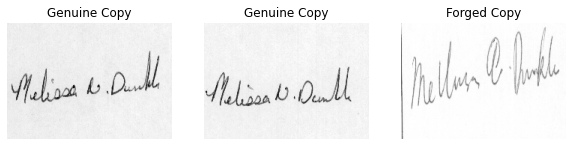

In [ ]:
visualize_sample_signature()

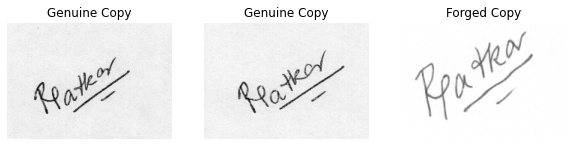

In [ ]:
visualize_sample_signature()

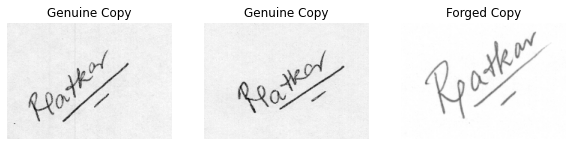

In [ ]:
visualize_sample_signature()

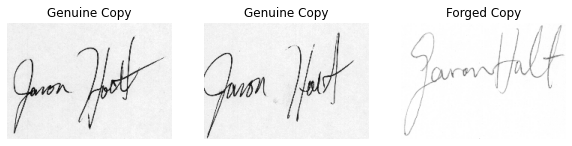

In [ ]:
visualize_sample_signature()

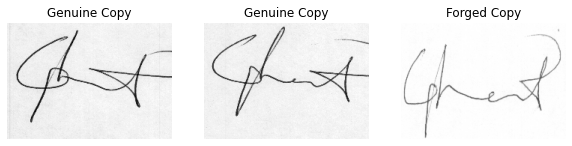

In [ ]:
visualize_sample_signature()

### Generate batch of original and forged group with data augmentation

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # New data-set has 12 signatures each

        # old-

        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 288 Genuine-Forged image pairs for one person.
        # In all we have 40 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 40 * 276 =# 33120
        # Total number of Genuine-Forged pairs = 40 * 300 = #36000
        # Total no. of data points = 33120 + 36000 = 69120
        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 6)))) #6 for 6 samples random
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    #epsilon is small constant (configurable as part of the constructor arguments)
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    
    seq.add(Flatten(name='flatten'))
   # When the network gets trained, this feature vector is then further use for classification, regression, or input into other network like RNN for translating into other type of output, etc.
   # It is also being used as a encoded vector. During training, this feature vector is being used to determine the loss, and help the network to get train.
   
    seq.add(Dense(1024, bias_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, bias_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return seq

In [ ]:
input_shape=(img_h, img_w, 1)

In [ ]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

In [ ]:
base_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 37, 53, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 53, 96)        148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 26, 96)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 22, 30, 96)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 18, 26, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 26, 256)       72        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 12, 256)        0

# Final Dataset

In [ ]:
batch_sz = 128
#num_train_samples = 276*40 + 288*40
#num_val_samples = num_test_samples = 276*10 + 288*10
#num_train_samples = 276*40 + 288*40
#num_val_samples = num_test_samples = 276*15 + 288*6
#num_train_samples, num_val_samples, num_test_samples

num_train_samples = 66*40 + 72*40
num_val_samples = 66*15 
num_test_samples = 72*6
num_train_samples, num_val_samples, num_test_samples

(5520, 990, 432)

In [ ]:
#import statistics
#each_Osignature = statistics.mode(orig_lengths)
#each_Fsignature = statistics.mode(forg_lengths)
#batch_sz = 128
#num_train_samples = (each_Osignature*(each_Osignature-1)/2)*len(orig_train) + each_Osignature*(each_Osignature/2)*len(orig_train)
#num_val_samples = (each_Osignature*(each_Osignature-1)/2)*len(orig_val) 
#num_test_samples = each_Osignature*(each_Osignature/2)*len(orig_test)
#num_train_samples, num_val_samples, num_test_samples

## Model Training

In [ ]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=['acc'])

In [ ]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/Weights/signet-Engsig61-{epoch:03d}.h5', monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=True,mode='min')
] #260-{epoch:03d}

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

In [ ]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 5,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/5
43/43 [==============================] - ETA: 0s - loss: 0.2286 - acc: 0.3421
Epoch 00001: val_loss improved from inf to 0.65194, saving model to /content/drive/My Drive/Weights/signet-Engsig61-001.h5
43/43 [==============================] - 75s 2s/step - loss: 0.2286 - acc: 0.3421 - val_loss: 0.6519 - val_acc: 0.6819
Epoch 2/5
43/43 [==============================] - ETA: 0s - loss: 0.2229 - acc: 0.3261
Epoch 00002: val_loss improved from 0.65194 to 0.65015, saving model to /content/drive/My Drive/Weights/signet-Engsig61-002.h5
43/43 [==============================] - 75s 2s/step - loss: 0.2229 - acc: 0.3261 - val_loss: 0.6501 - val_acc: 0.6808
Epoch 3/5
43/43 [==============================] - ETA: 0s - loss: 0.2227 - acc: 0.3239
Epoch 00003: val_loss did not improve from 0.65015
43/43 [==============================] - 74s 2s/step - loss: 0.2227 - acc: 0.3239 - val_loss: 0.6586 - val_acc: 0.7020
Epoch 4/5
43/43 [==============================] - ETA: 0s - loss: 0.2191 - ac

### After observing continuous fall in validation accuracy, I interrupted the training manually.
## Learning point: In Siamese Neural Network validation ...

# Validation

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [ ]:
model.load_weights('/content/drive/My Drive/Weights/signet-Engsig61-003.h5')

In [ ]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], [] #tr_y have label
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.7917021276595745, 0.01)

#### Accuracy = 89.71% and Threshold = 0.22 


Thus if the differnce score is less than 0.22, we predict the test image as Genuine and if the difference score is greater than 0.22, we predict it to be as forged

#### Below we see some sample results

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    #print(img1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

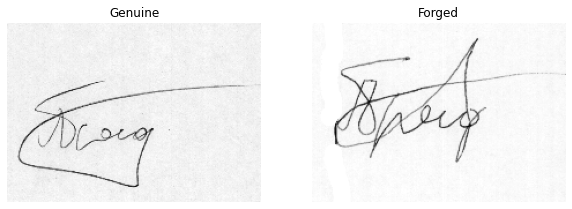

Difference Score =  0.035407078
Its a Forged Signature


In [ ]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image.

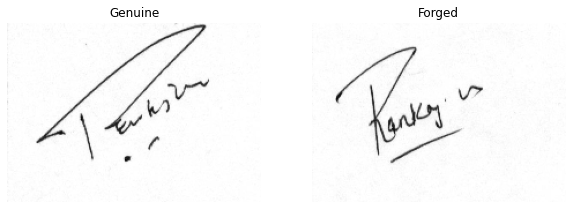

Difference Score =  0.014764763
Its a Forged Signature


In [ ]:
predict_score()

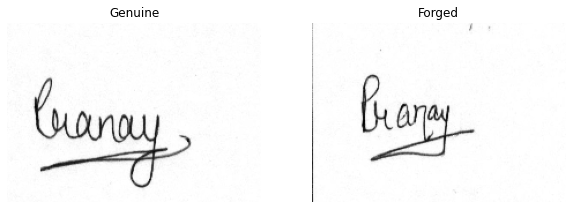

Difference Score =  0.010063001
Its a Forged Signature


In [ ]:
predict_score()

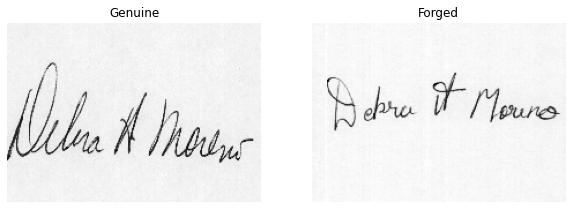

Difference Score =  0.023825537
Its a Forged Signature


In [ ]:
predict_score()

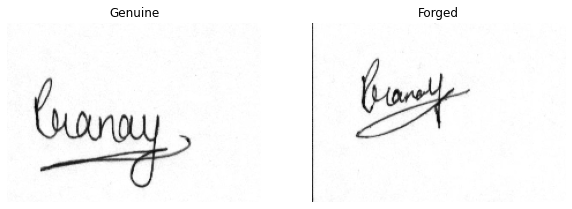

Difference Score =  0.014406716
Its a Forged Signature


In [ ]:
predict_score()

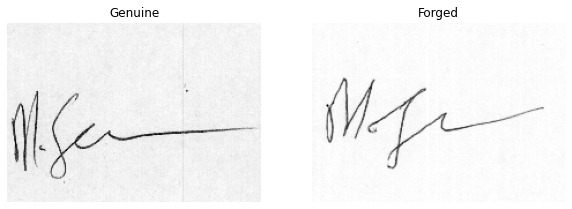

Difference Score =  0.033417992
Its a Forged Signature


In [ ]:
predict_score()

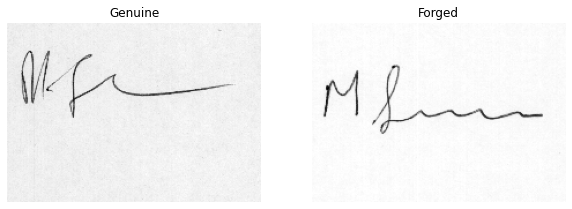

Difference Score =  0.025645085
Its a Forged Signature


In [ ]:
predict_score()

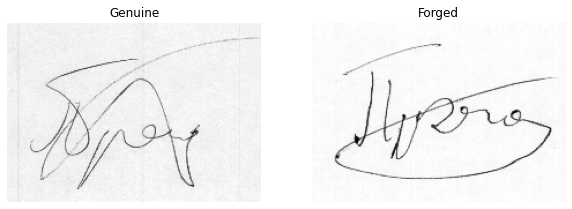

Difference Score =  0.026155585
Its a Forged Signature


In [ ]:
predict_score()

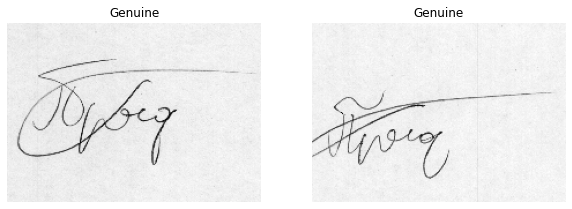

Difference Score =  0.009900751
Its a Genuine Signature


In [ ]:
predict_score()

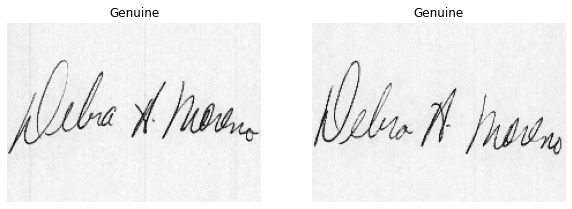

Difference Score =  0.010158686
Its a Forged Signature


In [ ]:
predict_score()

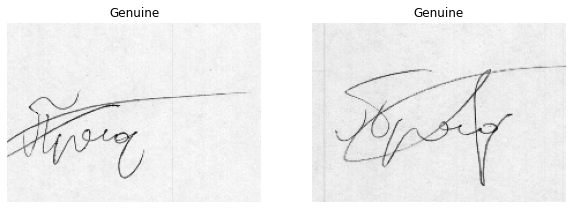

Difference Score =  0.0130870575
Its a Forged Signature


In [ ]:
predict_score()

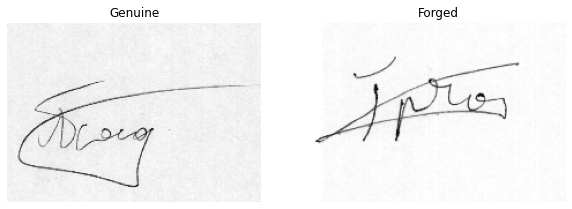

Difference Score =  0.035800714
Its a Forged Signature


In [ ]:
predict_score()

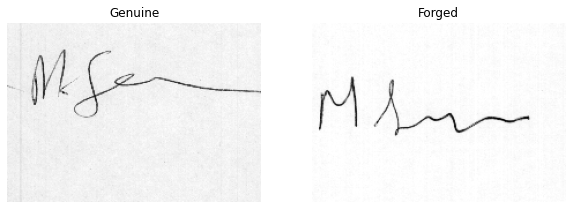

Difference Score =  0.017991621
Its a Forged Signature


In [ ]:
predict_score()

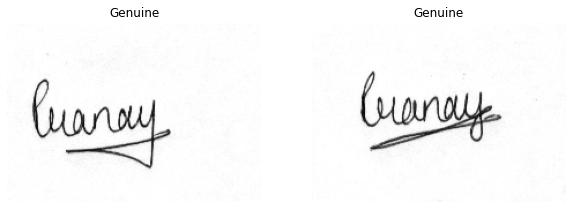

Difference Score =  0.008480304
Its a Genuine Signature


In [ ]:
predict_score()

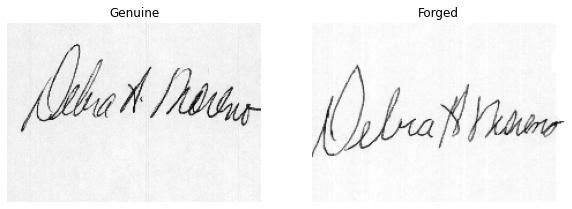

Difference Score =  0.017705452
Its a Forged Signature


In [ ]:
predict_score()

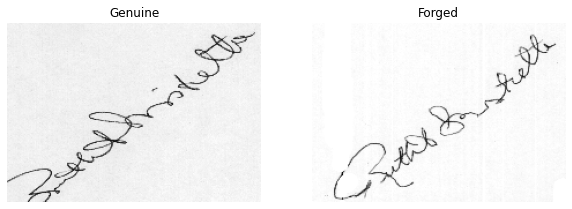

Difference Score =  0.025761701
Its a Forged Signature


In [ ]:
predict_score()

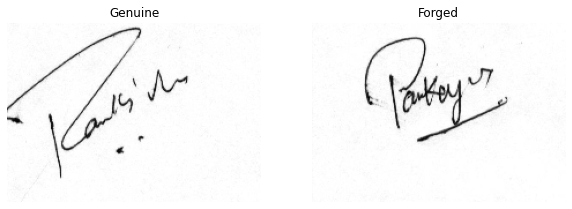

Difference Score =  0.011899101
Its a Forged Signature


In [ ]:
predict_score()

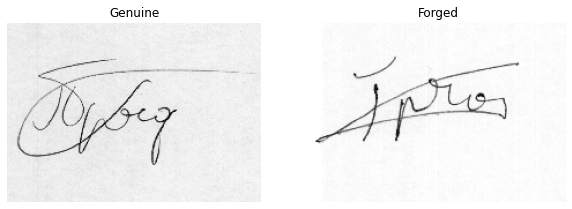

Difference Score =  0.030373635
Its a Forged Signature


In [ ]:
predict_score()

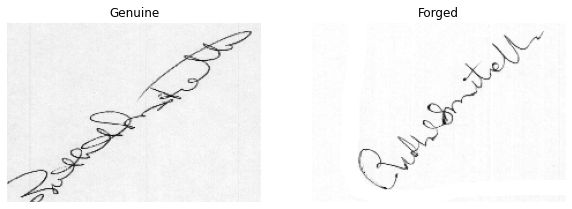

Difference Score =  0.02211534
Its a Forged Signature


In [ ]:
predict_score()

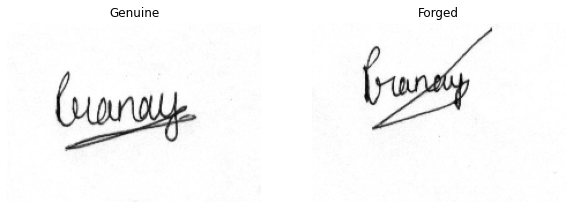

Difference Score =  0.015341498
Its a Forged Signature


In [ ]:
predict_score()

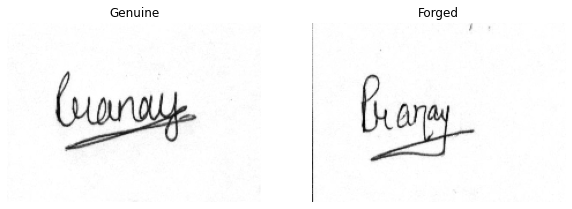

Difference Score =  0.0055512963
Its a Genuine Signature


In [ ]:
predict_score()

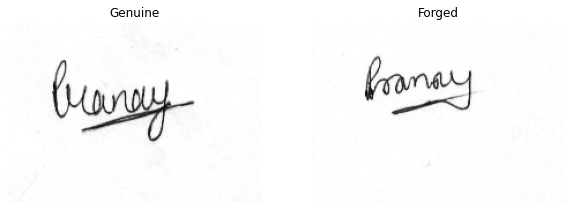

Difference Score =  0.011469509
Its a Forged Signature


In [ ]:
predict_score()

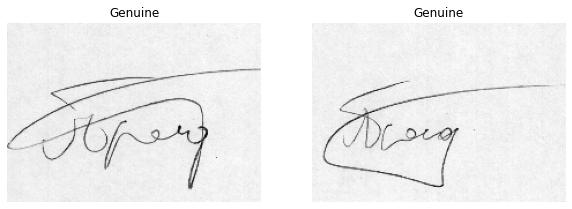

Difference Score =  0.0062156525
Its a Genuine Signature


In [ ]:
predict_score()

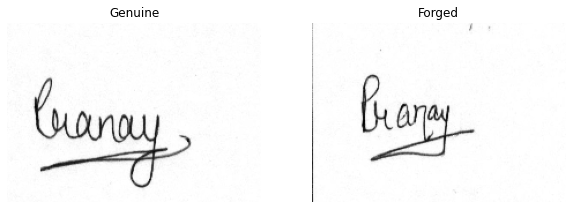

Difference Score =  0.010063001
Its a Forged Signature


In [ ]:
predict_score()

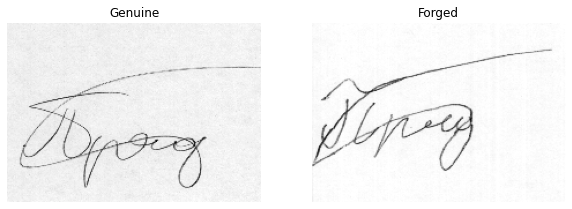

Difference Score =  0.034696374
Its a Forged Signature


In [ ]:
predict_score()

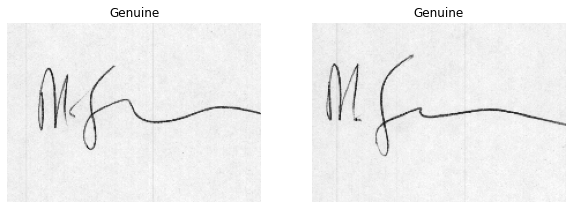

Difference Score =  0.003858123
Its a Genuine Signature


In [ ]:
predict_score()

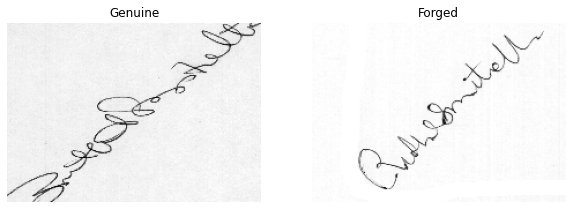

Difference Score =  0.029543182
Its a Forged Signature


In [ ]:
predict_score()

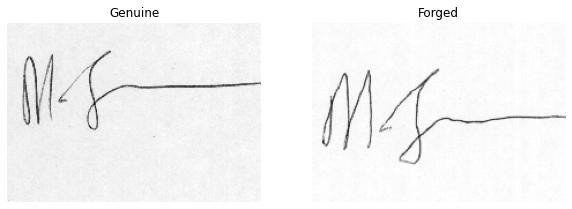

Difference Score =  0.027039303
Its a Forged Signature


In [ ]:
predict_score()

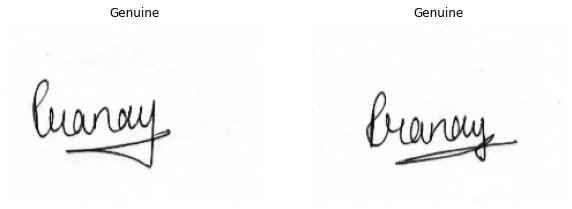

Difference Score =  0.010175899
Its a Forged Signature


In [ ]:
predict_score()

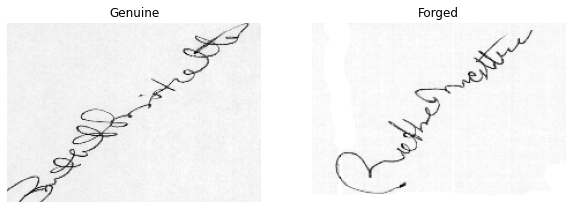

Difference Score =  0.02892428
Its a Forged Signature


In [ ]:
predict_score()

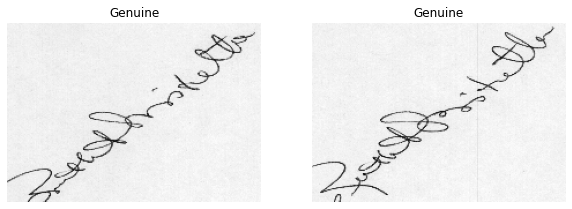

Difference Score =  0.0036719718
Its a Genuine Signature


In [ ]:
predict_score()

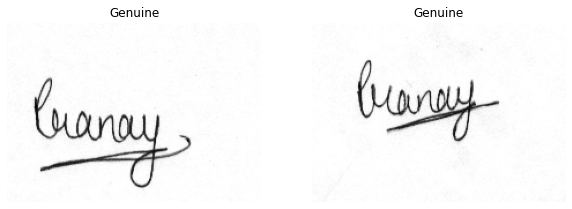

Difference Score =  0.014219472
Its a Forged Signature


In [ ]:
predict_score()

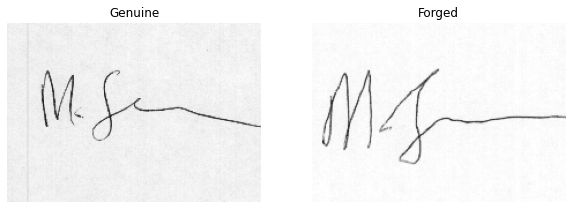

Difference Score =  0.02380401
Its a Forged Signature


In [ ]:
predict_score()

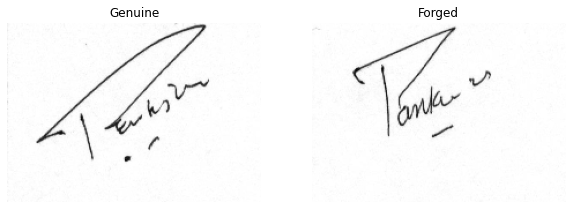

Difference Score =  0.01713414
Its a Forged Signature


In [ ]:
predict_score()

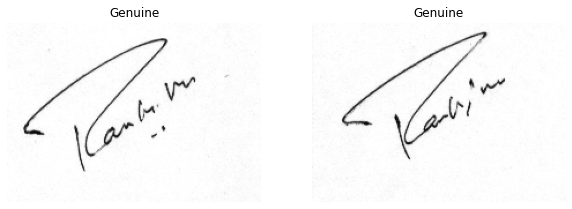

Difference Score =  0.003676581
Its a Genuine Signature


In [ ]:
predict_score()

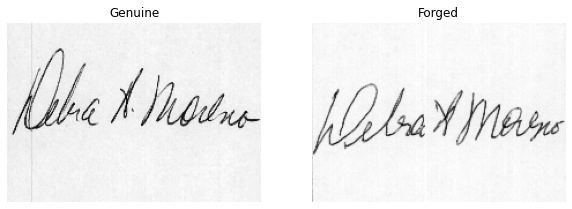

Difference Score =  0.01304144
Its a Forged Signature


In [ ]:
predict_score()

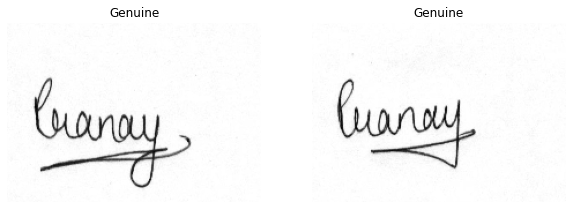

Difference Score =  0.003934327
Its a Genuine Signature


In [ ]:
predict_score()

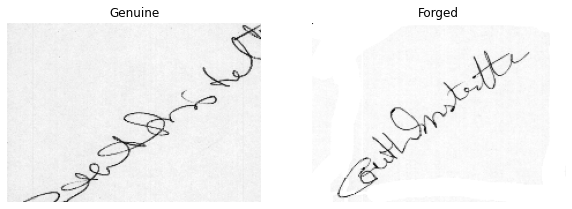

Difference Score =  0.02735879
Its a Forged Signature


In [ ]:
predict_score()

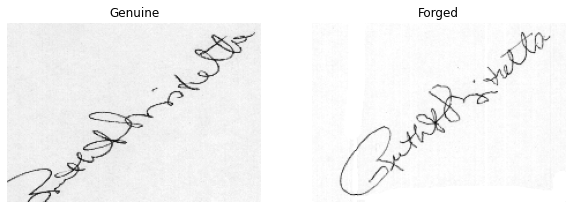

Difference Score =  0.026877057
Its a Forged Signature


In [ ]:
predict_score()

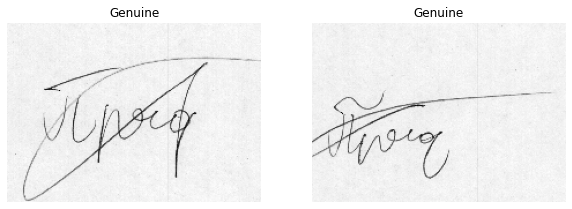

Difference Score =  0.009019202
Its a Genuine Signature


In [ ]:
predict_score()

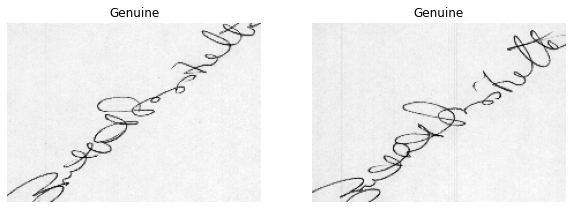

Difference Score =  0.003820588
Its a Genuine Signature


In [ ]:
predict_score()

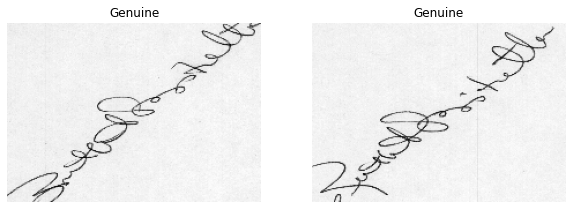

Difference Score =  0.0045343917
Its a Genuine Signature


In [ ]:
predict_score()

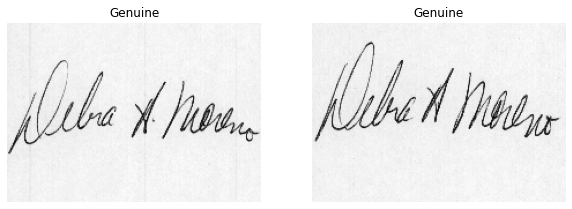

Difference Score =  0.006378214
Its a Genuine Signature


In [ ]:
predict_score()

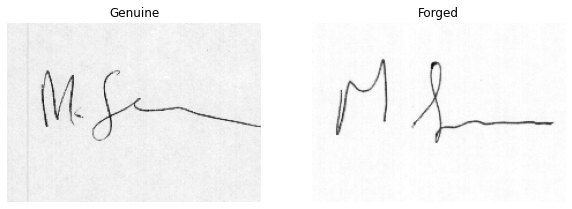

Difference Score =  0.022044707
Its a Forged Signature


In [ ]:
predict_score()

### Saving Model Architecture for further use.

In [ ]:
model_json=model.to_json()

In [ ]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
siamese_json=base_network.to_json()
with open("siamese_BaseNetwork.json","w") as json_file:
    json_file.write(siamese_json)